## Setup

In [1]:
import json
import click
from pathlib import Path
from shutil import make_archive
import os
import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from src.experiment import experiments, get_run_func
from src.utils import grid_search_dict

import numpy as np
from typing import Tuple, Optional, Dict, Any
from pathlib import Path

from src.utils.kernel_func import ColumnWiseGaussianKernel, AbsKernel, BinaryKernel, GaussianKernel
from src.data.ate import generate_train_data_ate, generate_test_data_ate, get_preprocessor_ate
from src.data.ate.data_class import PVTrainDataSet, PVTestDataSet
from src.models.PMMR.model import PMMRModel

import numpy as np
from typing import Tuple, Optional, Dict, Any
from pathlib import Path
import jax.numpy as jnp
import jax.scipy.linalg as jsla
import operator

from sklearn.preprocessing import StandardScaler

from src.utils.kernel_func import ColumnWiseGaussianKernel, AbsKernel, BinaryKernel, GaussianKernel
from src.data.ate import generate_train_data_ate, generate_test_data_ate, get_preprocessor_ate
from src.data.ate.data_class import PVTrainDataSet, PVTestDataSet, split_train_data
from src.utils.jax_utils import Hadamard_prod, mat_mul, mat_trans, modif_kron, cal_loocv_emb, cal_loocv_alpha, \
    stage2_weights
from src.models.kernelPV.model import get_kernel_func, KernelPVModel

C:\Users\Benedikt\anaconda3new\envs\kompa\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os.path as op
from pathlib import Path
from typing import Dict, Any

import numpy as np
import pandas as pd
import torch

from src.data.ate import generate_train_data_ate, generate_val_data_ate, generate_test_data_ate, get_preprocessor_ate
from src.data.ate.data_class import PVTrainDataSetTorch, PVTestDataSetTorch, RHCTestDataSetTorch
from src.models.NMMR.NMMR_trainers import NMMR_Trainer_DemandExperiment, NMMR_Trainer_dSpriteExperiment, \
    NMMR_Trainer_RHCExperiment

## Config

In [3]:
n_sample = 5000

pmmr_configs = {
    "n_repeat": 1,
    "data": {
        "name" : "demand",
        "n_sample" : n_sample,
        "Z_noise": [1],
        "W_noise": [1]
    },
    "model": {
        "name": "pmmr",
        "lam1": 0.01,
        "lam2": 0.01,
        "scale": 0.5,
        "data_scaling": True
    }
}

kpv_configs = {
    "n_repeat": 1,
    "data": {
        "name" : "demand",
        "n_sample" : n_sample,
        "preprocess" : "Identity",
        "Z_noise": [1],
        "W_noise": [1]
    },
    "model": {
        "name": "kpv",
        "lam1": 0.001,
        "lam2": 0.001,
        "split_ratio": 0.5,
        "scale": 0.5,
        "data_scaling": True,
    }
}

nmmr_u_configs = {
  "n_repeat": 1,
  "data": {
    "name": "demand",
    "n_sample": n_sample
  },
  "model": {
    "name": "nmmr",
    "n_epochs": 3000,
    "batch_size": 1000,
    "log_metrics": "False",
    "learning_rate": 0.003,
    "l2_penalty": 3e-06,
    "loss_name": "U_statistic",
    "network_depth": 4,
    "network_width": 80
  }
}

nmmr_v_configs = {
  "n_repeat": 1,
  "data": {
    "name": "demand",
    "n_sample": n_sample
  },
  "model": {
    "name": "nmmr",
    "n_epochs": 3000,
    "batch_size": 1000,
    "log_metrics": "False",
    "learning_rate": 0.003,
    "l2_penalty": 3e-06,
    "loss_name": "V_statistic",
    "network_depth": 3,
    "network_width": 80
  }
}

verbose = 2

## Functions

In [4]:
def pmmr_exp(data_config: Dict[str, Any], model_param: Dict[str, Any],
                     random_seed: int = 42, verbose: int = 0):
    train_data_org = generate_train_data_ate(data_config=data_config, rand_seed=random_seed)
    test_data_org = generate_test_data_ate(data_config=data_config)

    preprocessor = get_preprocessor_ate(data_config.get("preprocess", "Identity"))
    train_data = preprocessor.preprocess_for_train(train_data_org)
    test_data = preprocessor.preprocess_for_test_input(test_data_org)

    model = PMMRModel(**model_param)
    model.fit(train_data, data_config["name"])
    pred = model.predict(test_data.treatment)
    pred = preprocessor.postprocess_for_prediction(pred)
    
    mse = np.mean((pred - test_data.structural) ** 2)
    mae = np.mean(np.abs(pred - test_data.structural))
    
    return train_data_org, test_data_org, pred, mse, mae

In [5]:
def kpv_exp(data_config: Dict[str, Any], model_param: Dict[str, Any],
                    random_seed: int = 42, verbose: int = 0):
    train_data_org = generate_train_data_ate(data_config=data_config, rand_seed=random_seed)
    test_data_org = generate_test_data_ate(data_config=data_config)

    preprocessor = get_preprocessor_ate(data_config.get("preprocess", "Identity"))
    train_data = preprocessor.preprocess_for_train(train_data_org)
    test_data = preprocessor.preprocess_for_test_input(test_data_org)

    model = KernelPVModel(**model_param)
    model.fit(train_data, data_config["name"])
    pred = model.predict(test_data.treatment)
    pred = preprocessor.postprocess_for_prediction(pred)
    
    mse = np.mean((pred - test_data.structural) ** 2)
    mae = np.mean(np.abs(pred - test_data.structural))
    
    return train_data_org, test_data_org, pred, mse, mae

In [6]:
def NMMR_exp(data_config: Dict[str, Any], model_config: Dict[str, Any],
                    one_mdl_dump_dir: Path,
                    random_seed: int = 42, verbose: int = 0):
    # set random seeds
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)

    # generate train data
    train_data = generate_train_data_ate(data_config=data_config, rand_seed=random_seed)
    val_data = generate_val_data_ate(data_config=data_config, rand_seed=random_seed + 1)
    test_data = generate_test_data_ate(data_config=data_config)

    # convert datasets to Torch (for GPU runtime)
    train_t = PVTrainDataSetTorch.from_numpy(train_data)
    val_data_t = PVTrainDataSetTorch.from_numpy(val_data)

    data_name = data_config.get("name", None)
    if data_name in ['dsprite', 'demand']:
        test_data_t = PVTestDataSetTorch.from_numpy(test_data)
    elif data_name == 'rhc':
        test_data_t = RHCTestDataSetTorch.from_numpy(test_data)
    else:
        raise KeyError(f"Your data config contained name = {data_name}, but must be one of [dsprite, demand, rhc]")

    # retrieve the trainer for this experiment
    if data_name == "dsprite":
        trainer = NMMR_Trainer_dSpriteExperiment(data_config, model_config, random_seed, one_mdl_dump_dir)
    elif data_name == "demand":
        trainer = NMMR_Trainer_DemandExperiment(data_config, model_config, random_seed, one_mdl_dump_dir)
    elif data_name == 'rhc':
        trainer = NMMR_Trainer_RHCExperiment(data_config, model_config, random_seed, one_mdl_dump_dir)

    # train model
    model = trainer.train(train_t, val_data_t, verbose)

    # prepare test data on the gpu
    if trainer.gpu_flg:
        # torch.cuda.empty_cache()
        test_data_t = test_data_t.to_gpu()
        val_data_t = val_data_t.to_gpu()

    if data_name == "dsprite":
        E_wx_hawx = trainer.predict(model, test_data_t, val_data_t, batch_size=model_config.get('val_batch_size', None))
    elif data_name == "demand":
        E_wx_hawx = trainer.predict(model, test_data_t, val_data_t)
    elif data_name == "rhc":
        E_wx_hawx = trainer.predict(model, test_data_t)

    pred = E_wx_hawx.detach().numpy()
    np.savetxt(one_mdl_dump_dir.joinpath(f"{random_seed}.pred.txt"), pred)

    if hasattr(test_data, 'structural'):
        # test_data.structural is equivalent to EY_doA
        np.testing.assert_array_equal(pred.shape, test_data.structural.shape)
        oos_loss = np.mean((pred - test_data.structural) ** 2)
        
        mse = np.mean((pred - test_data.structural) ** 2)
        mae = np.mean(np.abs(pred - test_data.structural))
    else:
        oos_loss = None

        mse = None
        mae = None
    
    return train_data, test_data, pred, mse, mae

## Evaluations

In [7]:
%%time
data_config_pmmr = pmmr_configs["data"]
model_config_pmmr = pmmr_configs["model"]

train_data_pmmr, test_data_pmmr, pred_pmmr, mse_pmmr, mae_pmmr = pmmr_exp(data_config=data_config_pmmr, model_param=model_config_pmmr, random_seed = 42, verbose=verbose)
# CPU times: total: 1min 43s
# Wall time: 22.2 s

CPU times: total: 1min 47s
Wall time: 20.8 s


In [8]:
%%time
data_config_kpv = kpv_configs["data"]
model_config_kpv = kpv_configs["model"]

train_data_kpv, test_data_kpv, pred_kpv, mse_kpv, mae_kpv = kpv_exp(data_config=data_config_kpv, model_param=model_config_kpv, random_seed = 42, verbose=verbose)
# CPU times: total: 2min 57s
# Wall time: 2min 24s

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


CPU times: total: 2min 51s
Wall time: 2min 10s


In [9]:
%%time
DUMP_DIR = Path.cwd().joinpath('dumps')
data_config_nmmr_u = nmmr_u_configs["data"]
model_config_nmmr_u = nmmr_u_configs["model"]


train_data_nmmr_u, test_data_nmmr_u, pred_nmmr_u, mse_nmmr_u, mae_nmmr_u = NMMR_exp(data_config=data_config_nmmr_u, model_config=model_config_nmmr_u, one_mdl_dump_dir = DUMP_DIR, random_seed=42, verbose = verbose)
# CPU times: total: 8min 33s
# Wall time: 2min 16s

100%|██████████| 3000/3000 [11:38<00:00,  4.29it/s]

CPU times: total: 45min 48s
Wall time: 11min 38s


In [10]:
%%time
DUMP_DIR = Path.cwd().joinpath('dumps')
data_config_nmmr_v = nmmr_v_configs["data"]
model_config_nmmr_v = nmmr_v_configs["model"]


train_data_nmmr_v, test_data_nmmr_v, pred_nmmr_v, mse_nmmr_v, mae_nmmr_v = NMMR_exp(data_config=data_config_nmmr_v, model_config=model_config_nmmr_v, one_mdl_dump_dir = DUMP_DIR, random_seed=42, verbose = verbose)
# CPU times: total: 7min 58s
# Wall time: 2min 8s 

100%|██████████| 3000/3000 [11:05<00:00,  4.51it/s]

CPU times: total: 43min 41s
Wall time: 11min 5s


## Plots

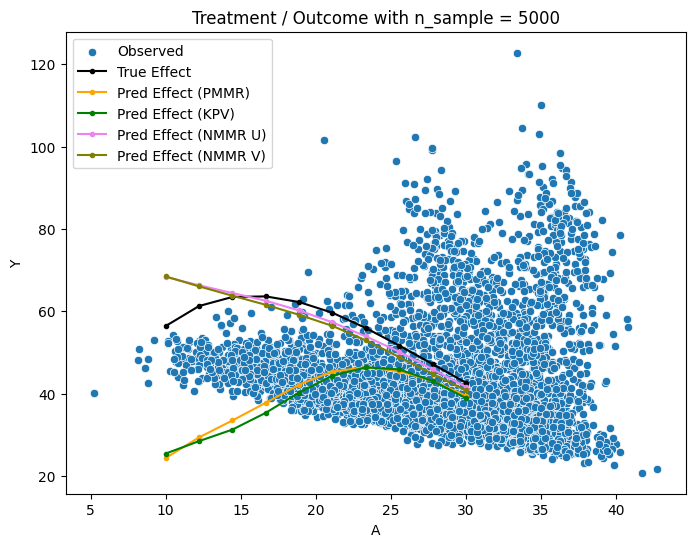

In [11]:
A_train = np.squeeze(train_data_pmmr.treatment)
Y_train = np.squeeze(train_data_pmmr.outcome)
A_test = test_data_pmmr.treatment
Y_test = test_data_pmmr.structural
Y_pred_pmmr = pred_pmmr
Y_pred_kpv = pred_kpv
Y_pred_nmmr_u = pred_nmmr_u
Y_pred_nmmr_v = pred_nmmr_v

plt.figure(figsize=(8, 6))
sns.scatterplot(x=A_train, y=Y_train, label='Observed')
plt.plot(A_test, Y_test, color='black', marker='o', label="True Effect", markersize = 3)
plt.plot(A_test, Y_pred_pmmr, color='orange', marker='o', label="Pred Effect (PMMR)", markersize = 3)
plt.plot(A_test, Y_pred_kpv, color='green', marker='o', label="Pred Effect (KPV)", markersize = 3)
plt.plot(A_test, Y_pred_nmmr_u, color='violet', marker='o', label="Pred Effect (NMMR U)", markersize = 3)
plt.plot(A_test, Y_pred_nmmr_v, color='olive', marker='o', label="Pred Effect (NMMR V)", markersize = 3)
plt.title(f'Treatment / Outcome with n_sample = {n_sample}')
plt.xlabel('A')
plt.ylabel('Y')
plt.legend()
plt.show()